<pre>
Introduction: What is Short-Term Memory (STM)?
Short-Term Memory in LLMs refers to the information the model can remember temporarily during a single interaction or conversation flow.
In LangGraph, short-term memory is typically stored in the graph state and passed between nodes while the graph executes.

📌 Key idea:
STM exists only during execution or within the context window of the model.

Without short-term memory, an LLM would behave like:
“I forgot what you just said.”

We need STM to:
Maintain conversation continuity
Track intermediate reasoning
Coordinate multi-step workflows

Context Window Limitations:
LLMs have a limited context window (e.g., 4,096 tokens for GPT-3.5).
STM must fit within this limit along with the prompt and response.

To solve this we use techniques like:
Summarization: Condense previous interactions to save space.
Trimming: Remove extra details and keep only last N interactions.
</pre>

### <code>Trimming Short-Term Memory</code>

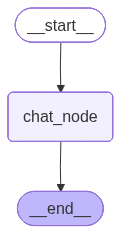

In [13]:
from langgraph.graph import StateGraph,START,END,MessagesState
from langgraph.checkpoint.memory import InMemorySaver
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages.utils import trim_messages,count_tokens_approximately
load_dotenv()

# Initialize the Google Gemini model
model = ChatGoogleGenerativeAI(model="gemini-2.5-flash-lite")
MAX_TOKENS = 150

# Define a node to handle chat interactions with message trimming
def chat_node(state: MessagesState) -> MessagesState:
  messages = trim_messages(
    state["messages"],
    strategy="last",
    max_tokens=MAX_TOKENS,
    token_counter=count_tokens_approximately,
  )
  print(f"Current token count: {count_tokens_approximately(messages=messages)}")
  
  for msg in messages:
    print(f"{msg.type}: {msg.content}")
  
  response = model.invoke(messages)
  return {"messages":[response]}

# Create the graph
graph = StateGraph(MessagesState)

graph.add_node("chat_node", chat_node)

graph.add_edge(START, "chat_node")
graph.add_edge("chat_node", END)

workflow = graph.compile(checkpointer=InMemorySaver())
workflow

In [14]:
config = {"configurable":{"thread_id":"id1"}}
workflow.invoke({"messages":[{"role":"user","content":"Hello My name is Ajay"}]},config=config)

Current token count: 10
human: Hello My name is Ajay


{'messages': [HumanMessage(content='Hello My name is Ajay', additional_kwargs={}, response_metadata={}, id='b91eff61-e7bb-4e2b-bb63-8ab1fa2a453e'),
  AIMessage(content="Hello Ajay! It's nice to meet you. How can I help you today?", additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019bd197-d4d3-77a3-839f-37c544d96c4a-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 6, 'output_tokens': 18, 'total_tokens': 24, 'input_token_details': {'cache_read': 0}})]}

In [ ]:
workflow.invoke({"messages":[{"role":"user","content":"Tell me about dog in 100 words"}]},config=config)

Current token count: 140
human: Hello My name is Ajay
ai: Hello Ajay! It's nice to meet you. How can I help you today?
human: Tell me about U
ai: I am a large language model, trained by Google.
human: Tell me about dog in 30 words
ai: Dogs are loyal, furry companions known for their playful nature and unwavering devotion. They bring joy, security, and unconditional love to their human families, making them cherished members of households worldwide.
human: Tell me about dog in 50 words


{'messages': [HumanMessage(content='Hello My name is Ajay', additional_kwargs={}, response_metadata={}, id='b91eff61-e7bb-4e2b-bb63-8ab1fa2a453e'),
  AIMessage(content="Hello Ajay! It's nice to meet you. How can I help you today?", additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019bd197-d4d3-77a3-839f-37c544d96c4a-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 6, 'output_tokens': 18, 'total_tokens': 24, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='Tell me about U', additional_kwargs={}, response_metadata={}, id='4dc40997-2f53-4173-9816-d26731207712'),
  AIMessage(content='I am a large language model, trained by Google.', additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019bd198-5415-7d83-a

In [18]:
workflow.invoke({"messages":[{"role":"user","content":"How many legs does a dog have?"}]},config=config)

Current token count: 116
human: Tell me about dog in 50 words
ai: Dogs are beloved canine companions, renowned for their loyalty, playful spirit, and diverse breeds. These intelligent animals offer unwavering devotion, providing comfort, security, and endless entertainment. From energetic adventurers to cuddly lapdogs, they enrich human lives immeasurably with their unique personalities and unconditional love.
human: How many legs does a dog have?


{'messages': [HumanMessage(content='Hello My name is Ajay', additional_kwargs={}, response_metadata={}, id='b91eff61-e7bb-4e2b-bb63-8ab1fa2a453e'),
  AIMessage(content="Hello Ajay! It's nice to meet you. How can I help you today?", additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019bd197-d4d3-77a3-839f-37c544d96c4a-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 6, 'output_tokens': 18, 'total_tokens': 24, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='Tell me about U', additional_kwargs={}, response_metadata={}, id='4dc40997-2f53-4173-9816-d26731207712'),
  AIMessage(content='I am a large language model, trained by Google.', additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019bd198-5415-7d83-a

### <code>Summarization of Short-Term Memory</code>

#### <code> Deleteting Old N messages</code>

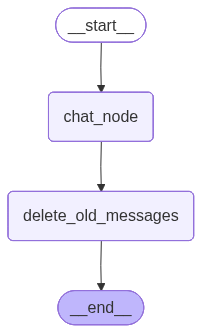

In [24]:
from langgraph.graph import StateGraph,START,END,MessagesState
from langgraph.checkpoint.memory import InMemorySaver
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import RemoveMessage 
load_dotenv()

# Initialize the Google Gemini model
model = ChatGoogleGenerativeAI(model="gemini-2.5-flash")
MAX_TOKENS = 150

# Define a node to handle chat interactions with message trimming
def chat_node(state: MessagesState) -> MessagesState:
  response = model.invoke(state["messages"])
  return {"messages":[response]}

# Delete old N masg
def delete_old_messages(state:MessagesState) -> MessagesState:
  msgs = state["messages"]
  
  if len(msgs) > 10:
    to_remove = msgs[:6]
    return {"messages":[RemoveMessage(id=msg.id) for msg in to_remove]}
  
  return {}
  
# Create the graph
graph = StateGraph(MessagesState)

graph.add_node("chat_node", chat_node)
graph.add_node("delete_old_messages", delete_old_messages)

graph.add_edge(START, "chat_node")
graph.add_edge("chat_node", "delete_old_messages")
graph.add_edge("delete_old_messages", END)

workflow = graph.compile(checkpointer=InMemorySaver())
workflow

In [25]:
config = {"configurable":{"thread_id":"id1"}}

workflow.invoke({"messages": [{"role": "user", "content": "Hi, I'm Nitish"}]}, config)
workflow.invoke({"messages": [{"role": "user", "content": "Tell me about LangGraph"}]}, config)
workflow.invoke({"messages": [{"role": "user", "content": "Now explain checkpointers"}]}, config)
workflow.invoke({"messages": [{"role": "user", "content": "What is Langchain"}]}, config)
workflow.invoke({"messages": [{"role": "user", "content": "What is Quantum Mechanics"}]}, config)
workflow.invoke({"messages": [{"role": "user", "content": "What is my name?"}]}, config)

{'messages': [HumanMessage(content='What is Langchain', additional_kwargs={}, response_metadata={}, id='f3286a93-6f31-4615-8eed-9f8919a4e36c'),
  AIMessage(content='Okay, Nitish, building on our discussion of LangGraph, let\'s zoom out a bit to understand its parent framework: **LangChain**.\n\n---\n\n### What is LangChain?\n\n**LangChain is an open-source framework designed to help developers build applications powered by Large Language Models (LLMs).**\n\nIn simpler terms, while LLMs are incredibly powerful, interacting with them directly through their raw APIs can be challenging for complex tasks. LangChain provides a structured way to:\n\n1.  **Connect LLMs to external data sources:** Give LLMs access to up-to-date information, private documents, or specific knowledge bases.\n2.  **Allow LLMs to interact with their environment:** Enable LLMs to use tools (like search engines, calculators, APIs) to perform actions.\n3.  **Orchestrate complex sequences of LLM calls and other componen

In [37]:
msg = workflow.get_state(config=config)
msg.values

{'messages': [HumanMessage(content='What is Langchain', additional_kwargs={}, response_metadata={}, id='f3286a93-6f31-4615-8eed-9f8919a4e36c'),
  AIMessage(content='Okay, Nitish, building on our discussion of LangGraph, let\'s zoom out a bit to understand its parent framework: **LangChain**.\n\n---\n\n### What is LangChain?\n\n**LangChain is an open-source framework designed to help developers build applications powered by Large Language Models (LLMs).**\n\nIn simpler terms, while LLMs are incredibly powerful, interacting with them directly through their raw APIs can be challenging for complex tasks. LangChain provides a structured way to:\n\n1.  **Connect LLMs to external data sources:** Give LLMs access to up-to-date information, private documents, or specific knowledge bases.\n2.  **Allow LLMs to interact with their environment:** Enable LLMs to use tools (like search engines, calculators, APIs) to perform actions.\n3.  **Orchestrate complex sequences of LLM calls and other componen

#### <code> Summarizing & Removing Old N messages</code>

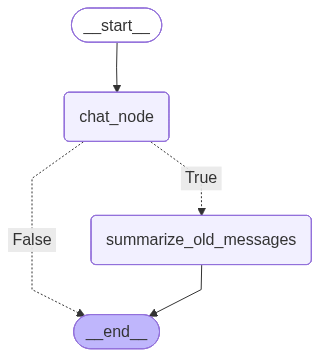

In [16]:
from langgraph.graph import StateGraph,START,END,MessagesState
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.messages import HumanMessage
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import RemoveMessage 
load_dotenv()

# Initialize the Google Gemini model
model = ChatGoogleGenerativeAI(model="gemini-2.5-flash")
MAX_TOKENS = 150

class ChatState(MessagesState):
  summary: str 

# Define a node to handle chat interactions with message trimming
def chat_node(state: ChatState) -> ChatState:
  messages = []
  
  if state["summary"]:
    messages.append({
      "role":"system",
      "content":f"Here is a summary of previous conversation: {state['summary']}"
    })
    
  messages.extend(state["messages"])
  print(messages)
  response = model.invoke(messages)
  return {"messages":[response]}

def summarize_old_messages(state:ChatState) -> ChatState:
  existing_summary = state["summary"]
  
  if existing_summary:
    prompt = f"Here is the existing summary of our conversation: {existing_summary}\n\nPlease update this summary with the following new messages:\n"
  else:
    prompt = "Please provide a concise summary of the following conversation:\n"
    
  messages_for_summary = state["messages"] + [HumanMessage(content=prompt)]
  
  response = model.invoke(messages_for_summary)
  
  messages_for_deletion = state["messages"][:-2]
  
  return {
    "summary": response.content,
    "messages": [RemoveMessage(id=msg.id) for msg in messages_for_deletion]
  }


def summarizetion_condition(state:ChatState) -> bool:
  return len(state["messages"]) > 6
  
# Create the graph
graph = StateGraph(ChatState)

graph.add_node("chat_node", chat_node)
graph.add_node("summarize_old_messages", summarize_old_messages)

graph.add_edge(START, "chat_node")
graph.add_conditional_edges(
  "chat_node",
  summarizetion_condition,
  {
    True: "summarize_old_messages",
    False: "__end__"
  })
graph.add_edge("summarize_old_messages", END)
workflow = graph.compile(checkpointer=InMemorySaver())
workflow

In [27]:
config = {"configurable":{"thread_id":"id3"}}

# gives the current version of the state
def show_state():
  snap = workflow.get_state(config)
  vals = snap.values
  print("\n --- STATE --- ")
  print ("summary:", vals.get("summary", "") )
  print("num_messages:", len(vals.get("messages", []) ) )
  print ("messages:")
  for m in vals.get("messages", []):
    print(":", m.content [:80] )

In [28]:
out = workflow.invoke({"messages": [{"role": "user", "content": "Hello My name is Ajay"}],"summary": ""},config=config)
print(out)
show_state()

[HumanMessage(content='Hello My name is Ajay', additional_kwargs={}, response_metadata={}, id='310c5fea-c88a-4c71-bdc7-c3016fe2b24f')]
{'messages': [HumanMessage(content='Hello My name is Ajay', additional_kwargs={}, response_metadata={}, id='310c5fea-c88a-4c71-bdc7-c3016fe2b24f'), AIMessage(content="Hello Ajay! It's nice to meet you. How can I help you today?", additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019bd1ef-962e-7181-9e5b-91ff020246af-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 6, 'output_tokens': 395, 'total_tokens': 401, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 377}})], 'summary': ''}

 --- STATE --- 
summary: 
num_messages: 2
messages:
: Hello My name is Ajay
: Hello Ajay! It's nice to meet you. How can I help you today?


In [29]:
output = workflow.invoke({"messages": [{"role": "user", "content": "How are you today?"}]},config=config)
print(output)
show_state()

[HumanMessage(content='Hello My name is Ajay', additional_kwargs={}, response_metadata={}, id='310c5fea-c88a-4c71-bdc7-c3016fe2b24f'), AIMessage(content="Hello Ajay! It's nice to meet you. How can I help you today?", additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019bd1ef-962e-7181-9e5b-91ff020246af-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 6, 'output_tokens': 395, 'total_tokens': 401, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 377}}), HumanMessage(content='How are you today?', additional_kwargs={}, response_metadata={}, id='523243fa-4b18-4304-9c90-903b1be46def')]
{'messages': [HumanMessage(content='Hello My name is Ajay', additional_kwargs={}, response_metadata={}, id='310c5fea-c88a-4c71-bdc7-c3016fe2b24f'), AIMessage(content="Hello Ajay! It's nice to meet you. How can I help you today?", addition

In [30]:
out = workflow.invoke({"messages": [{"role": "user", "content": "What is today date?"}]}, config=config)
print(out)
show_state()

[HumanMessage(content='Hello My name is Ajay', additional_kwargs={}, response_metadata={}, id='310c5fea-c88a-4c71-bdc7-c3016fe2b24f'), AIMessage(content="Hello Ajay! It's nice to meet you. How can I help you today?", additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019bd1ef-962e-7181-9e5b-91ff020246af-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 6, 'output_tokens': 395, 'total_tokens': 401, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 377}}), HumanMessage(content='How are you today?', additional_kwargs={}, response_metadata={}, id='523243fa-4b18-4304-9c90-903b1be46def'), AIMessage(content='As an AI, I don\'t have feelings or personal experiences like humans do, so I can\'t be "good" or "bad" in the same way.\n\nHowever, I am functioning perfectly and ready to assist you!\n\nHow are **you** doing today, Aj

In [ ]:
out = workflow.invoke({"messages": [{"role": "user", "content": "Tell me about dog in 20 words"}],"summary": ""},config=config)
print(out)
show_state()

[HumanMessage(content='Hello My name is Ajay', additional_kwargs={}, response_metadata={}, id='310c5fea-c88a-4c71-bdc7-c3016fe2b24f'), AIMessage(content="Hello Ajay! It's nice to meet you. How can I help you today?", additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019bd1ef-962e-7181-9e5b-91ff020246af-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 6, 'output_tokens': 395, 'total_tokens': 401, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 377}}), HumanMessage(content='How are you today?', additional_kwargs={}, response_metadata={}, id='523243fa-4b18-4304-9c90-903b1be46def'), AIMessage(content='As an AI, I don\'t have feelings or personal experiences like humans do, so I can\'t be "good" or "bad" in the same way.\n\nHowever, I am functioning perfectly and ready to assist you!\n\nHow are **you** doing today, Aj

In [35]:
out = workflow.invoke({"messages": [{"role": "user", "content": "What is my name and which animal do I like?"}]}, config=config)
print(out)
show_state()

[{'role': 'system', 'content': "Here is a summary of previous conversation: This conversation began with you, Ajay, introducing yourself. We then exchanged greetings, you asked about my well-being (to which I explained my AI nature), and I provided today's date (May 15, 2024). Finally, I gave a 20-word description of dogs as loyal, furry companions."}, HumanMessage(content='Tell me about dog in 20 words', additional_kwargs={}, response_metadata={}, id='9132307d-c555-410f-b624-c7d41359a67e'), AIMessage(content='Dogs are loyal, furry companions, beloved pets known for their playful nature, diverse breeds, and unwavering friendship, bringing joy to many.', additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019bd1f0-000d-72e1-8681-9c04683b1d26-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 124, 'output_tokens': 169, 'total_tokens': 293, 'input_tok